<a href="https://colab.research.google.com/github/myczu/AI/blob/main/WM_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
This project should introduce you to transfer learning techniques. The checklist below shows the steps necessary to finish the project.
- **Prepare a dataset**. The dataset shall be desined for image classification, and be organized to work with keras.applications (training, validation and test data should be in different folders. Images from one class should be in one subfolder).
- **Select the network**. Select the network you want to work with. In the original code `Xception` network is selected, but you may change it if you want.
- **Complete functions**. Complete missing code in the following functions
    - `add_new_last_layer` - adds an output layer to your model. You may also add some layers in between. If so, remember to unfreeze these layers in `setup_to_transfer_learn` function
    - `setup_to_transfer_learn` - Freezes all layers but the last one and compiles the model
    - `setup_to_finetune` - Freezes the first not_trainable layers, and unfreezes the rest
    - `train_generator` - Creates a generator feed with train dataset. You should add data augmentation to it
- **Perorm training**. Perform model trainig slowly unfreezeng the layers as long as you do not observe overfitting. In case of overfitting get back to previous model.
- **Test your model on real images**. Write a code that tests your model on real images. You should display an image, a real class of an image, the class selected by the model, and the probabilities assined by the model to all the classes.

In [ ]:
import os
import sys
import glob

import numpy as np
import pickle

import matplotlib.pyplot as plt

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Nadam

%matplotlib inline

In [ ]:
# Run if you are using google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run to see how to access your google drive
!ls "/content/drive/My Drive/"

 1118.PNG
 255.PNG
 25.PNG
'42 kod.PNG'
 44.PNG
 abecadlozpiecaspadlo.txt
'AiSD_wykład_05 - zadania 1 i 2.gdoc'
'AiSD_wykład_05 - zadanie 3.gdoc'
 AiSD_zadania_7.gdoc
'Arkusz kalkulacyjny bez tytułu.gsheet'
 case.PNG
'Cisco-IOS-ściąga (1).docx'
 Classroom
'Colab Notebooks'
 const.gdoc
'cw2 myczu.xlsx'
 cw3.4.gsheet
 cw3.txt
'Ćwiczenia 3 - rozwiązania (1).gsheet'
'Ćwiczenia 3 - rozwiązania (2).gsheet'
'Ćwiczenia 3 - rozwiązania.gsheet'
'dane mac'
'Diagram bez tytułu.drawio'
 diagram_sql.gsheet
'Dokument bez tytułu.gdoc'
 dyplom2.bw
 dyplom.bw
 identifier
 if.PNG
 IMG_5431.JPG
'instnwnd.zip (Unzipped Files)'
'knowledge base semestr.docx'
'Koszty ACID.gsheet'
 LinearRegression.txt
'Linux - uprawnienia i procesy (1).gdoc'
'Linux - uprawnienia i procesy.gdoc'
'Logistic regression.ipynb'
'“MD” Modern Developers.gslides'
 mobilebasic
 myczcw4.gdoc
 myczcw4.txt
'ostratnie zad.PNG'
 plynnosc.bw
 Plynnosc_tablice_decyzyjne.xlsx
 plynnosc.txt
 plynnosc.zw
 programowanie
 PROJEKTY
'Raport 

In [ ]:
# If you have more than 1 GPU and you want to train on the first one only
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
def get_nb_files(directory): #funkcja sprawdzająca ile znajduje się plików w danym folderze
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        print ('No directory')
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
              cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def add_new_last_layer(base_model, nb_classes): #funkcja dodająca ostatnia warstwe do naszego modelu
    """Add last layer to the convnet
    Arguments:
        base_model: keras model (without a top layer)
        nb_classes: number of classes
    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)                      #przekształca wyjście o dowolnym kształcie na wyjście o stałej długości, niezależne od rozmiaru obrazu.
    # Add the last layer and ((optionally) a dense layer
    # ENTER YOUR CODE HERE
    predictions = Dense(nb_classes, activation='softmax')(x)
    #END OF YOUR CODE
    model = Model(inputs=base_model.input, outputs=predictions)     #zastepujemy wyjściową warstwę warstwą predictions
    return model



def setup_to_transfer_learn(model, args):
    """Freezes all layers but the last one and compiles the model"""

    # TODO: Set all the layers but last one to not trainable.
    # Note: If you added more than one layer in the add_new_last_layer
    # function you should set all these layers to trainable.
    #ENTER YOUR CODE HERE
    for layer in model.layers[:-1]: #zamrażamy wszystkie warstwy oprócz ostatniej, bo ją chcemy trenować
            layer.trainable = False
    #END OF YOUR CODE
    model.layers[-1].trainable=True    #pozwalamy na trenowanie ostatniej warstwy
    opt = Nadam(lr=args.lr)            #alogrytm którego użyjemy podczas trenowania z określonym learning rate
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def setup_to_finetune(model, args, not_trainable):                   #funkcja slużąca do dalszego fine-tuningu czyli do dalszego odmrażania kolejnych warstw modelu
    """Freezes the first not_trainable layers, and unfreezes the rest
    Arguments:
        model: keras model
        not_trainable: number of not trainable layers
    """

    #Set the layers [0:not_trainable] to not trainable. Set the layers [not_trainable:] to trainable
    #ENTER YOUR CODE HERE

    for layer in model.layers[0:not_trainable]: #ustawia od pierwszej do ktorejś warstwy na nietrenowalna
        layer.trainable = False

    #END OF YOUR CODE

    opt = Nadam(lr=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def trainable_params(model, output_format = 'en_US'):  #funkcja ktora oblicza nam ile parametrów jest trenowalnych
    """Computes the number of trainable parameters in the model.
    Args:
        model: keras model
        output_format: (default: 'en_US')
            'int'   - number of trainable parameters (12345)
            'en_US' - number of trainable parameters formated to comma separated str ('12,235')
    """

    def nr_to_string(number, separator = ','):
        """
        Changes numbers to string.
        """
        s = '%d' % number
        groups = []
        while s and s[-1].isdigit():
            groups.append(s[-3:])
            s = s[:-3]
        return s + separator.join(reversed(groups))

    # And the real trainable_params function

    ret = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    if output_format == 'en_US':
        return nr_to_string(ret)
    else:
        return ret


### Plot results

In [ ]:
def unpack_history(history, old_history = None):
    if old_history is None:
        new_history = {
            'accuracy' : [],
            'val_accuracy' : [],
            'loss' : [],
            'val_loss' : [],
        }
    else:
        new_history = old_history
    new_history['accuracy'] += history.history['accuracy']
    new_history['val_accuracy'] += history.history['val_accuracy']
    new_history['loss'] += history.history['loss']
    new_history['val_loss'] += history.history['val_loss']
    return new_history

def plot_history(training_history):
    acc = training_history['accuracy']
    val_acc = training_history['val_accuracy']
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = np.arange(len(acc)) + 1

    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(121)
    ax1.plot(epochs, loss, c='g', label='Train')
    ax1.plot(epochs, val_loss, c='r', label='Valid')
    ax1.set_title('Loss')
    ax1.legend(loc='lower left');
    ax1.grid(True)

    ax2 = fig.add_subplot(122)
    ax2.plot(epochs, acc, c='g', label='Train')
    ax2.plot(epochs, val_acc, c='r', label='Valid')
    ax2.set_title('Accuracy')
    #ax2.legend(loc='upper left');
    ax2.grid(True)

    plt.show()


def process_and_display(history, old_history = None):
    new_history = unpack_history(history, old_history)
    plot_history(new_history)
    return new_history



### Hyperparameters

In [ ]:
class Args():
    def __init__(self):

        self.im_width, self.im_height = 299, 299 #fixed size for Xception
        self.lr = 0.001
        self.batch_size = 128

        local_folder = '/content/drive/MyDrive/PROJEKTY/AI/splited dataset'
        self.train_dir = os.path.join(local_folder, 'train/')
        self.valid_dir = os.path.join(local_folder, 'valid/')
        self.test_dir = os.path.join(local_folder, 'test/')

args = Args()


### Prepare global variables

In [ ]:
nb_train_samples = get_nb_files(args.train_dir)   #ile jest plików w zbiorze treningowym
classes = glob.glob(args.train_dir + "/*")        #znajduje wszystkie katalogi w treningowym katalogu
classes = [x.split('/')[-1] for x in classes]     #robi liste klas
classes.sort()
nb_classes = len(classes)    #liczba klas
nb_valid_samples = get_nb_files(args.valid_dir)   #ile jest plików w zbiorze walidaycjnym

train_steps = int(nb_train_samples / args.batch_size)   #liczba batchy w każdej epoce
valid_steps = int (nb_valid_samples / args.batch_size)

print ('Train dataset contains {} samples ({} steps / epoch)'.format(nb_train_samples, train_steps))
print ('Valid dataset contains {} samples ({} steps / epoch)'.format(nb_valid_samples, valid_steps))
print ('Dataset contains {} classes ({}).'.format(nb_classes, classes))


Train dataset contains 2873 samples (22 steps / epoch)
Valid dataset contains 615 samples (4 steps / epoch)
Dataset contains 5 classes (['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']).


### Generators

In [ ]:
# add data augmentation to the generator
train_datagen = ImageDataGenerator(             #obiekt do generowania dodatkowych danych poprzez różne techniki
    preprocessing_function=preprocess_input,
    #ENTER YOUR CODE
    rotation_range=20,  # Obrót obrazu o kąt w zakresie [-20, 20] stopni
    zoom_range=0.2,  # Powiększenie/zbliżenie obrazu o zakres 20%
    horizontal_flip=True,  # Odbicie lustrzane obrazu w poziomie
    vertical_flip=True,  # Odbicie lustrzane obrazu w pionie
    #END OF YOUR CODE
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,      #przetwarzanie wstępne obrazów w testowym
)

train_generator = train_datagen.flow_from_directory(
    args.train_dir,
    target_size=(args.im_width, args.im_height),           #skalujemy obrazy
    batch_size=args.batch_size,
)

validation_generator = test_datagen.flow_from_directory(             #używamy test_datagen bo chcemy zrobic tylko preprocessing
    args.valid_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

test_generator = test_datagen.flow_from_directory(          #to samo co w validation_generator
    args.test_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size
)

Found 2873 images belonging to 5 classes.
Found 615 images belonging to 5 classes.
Found 622 images belonging to 5 classes.


### Model

In [ ]:
model = Xception(weights='imagenet', include_top=False)   #model Xception z wczytanymi wagami wytrenowanymi na modelu imagenet, include_top = false mówi nam że ostatnia warstwa klasyfikująca zostaje wyłączona i możemy sami ją dodać
model = add_new_last_layer(model, nb_classes)   #dodanie naszej warstwy klasyfikującej na podstawie klas z naszego data setu

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                      

## Training

### TODO: Perform training (transfer learning and fine tuning) to get the best results you can.


### Transfer learning

In [ ]:
setup_to_transfer_learn(model, args)     #zamrożenie wszystkich warstw oprócz ostatniej

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 5,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/5
22/22 [==============================] - 688s 31s/step - loss: 1.2540 - accuracy: 0.5796 - val_loss: 0.9031 - val_accuracy: 0.7676
Epoch 2/5
22/22 [==============================] - 83s 4s/step - loss: 0.7723 - accuracy: 0.7749 - val_loss: 0.6539 - val_accuracy: 0.8105
Epoch 3/5
22/22 [==============================] - 83s 4s/step - loss: 0.6027 - accuracy: 0.8244 - val_loss: 0.5402 - val_accuracy: 0.8477
Epoch 4/5
22/22 [==============================] - 82s 4s/step - loss: 0.5242 - accuracy: 0.8393 - val_loss: 0.4628 - val_accuracy: 0.8672
Epoch 5/5
22/22 [==============================] - 84s 4s/step - loss: 0.4911 - accuracy: 0.8459 - val_loss: 0.4527 - val_accuracy: 0.8613


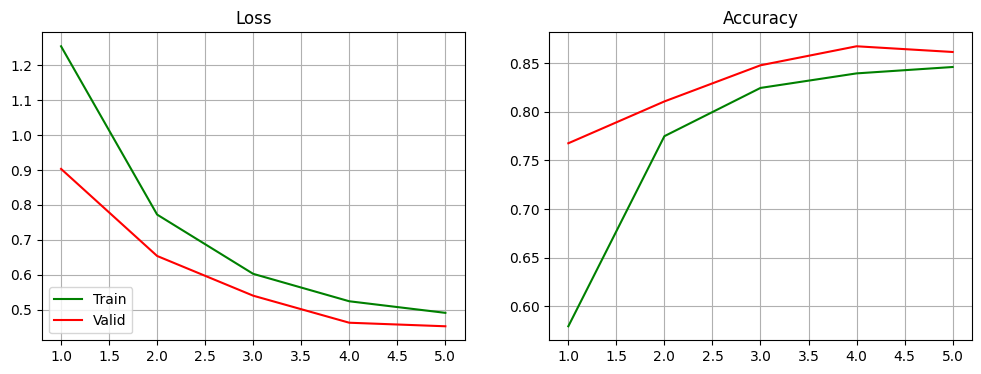

In [ ]:
tl_history = process_and_display(history)
model.save_weights('checkpoints/transfer_learning')

### Fine tuning

In [ ]:
model.layers[126].get_config()['name']

'block14_sepconv1'

In [ ]:
setup_to_finetune(model, args, not_trainable=126)    #odmrażamy jedna z warstw

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/2
22/22 [==============================] - 85s 4s/step - loss: 0.4498 - accuracy: 0.8583 - val_loss: 0.4133 - val_accuracy: 0.8750
Epoch 2/2
22/22 [==============================] - 83s 4s/step - loss: 0.4024 - accuracy: 0.8725 - val_loss: 0.3949 - val_accuracy: 0.8730


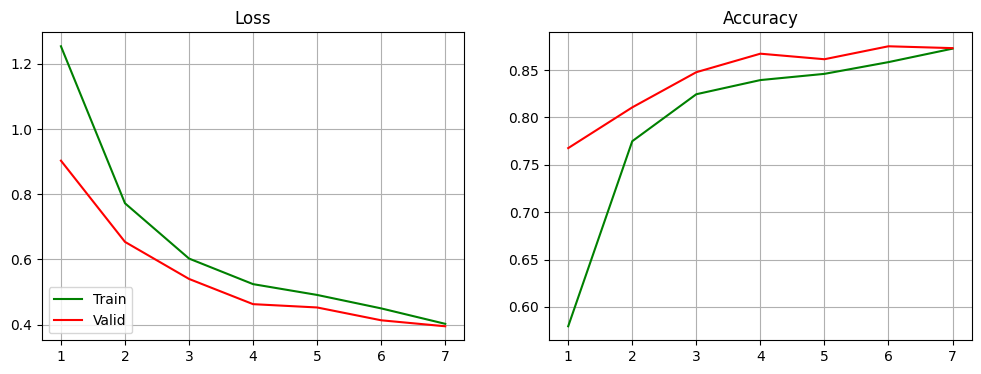

In [ ]:
ft126_history = process_and_display(history, tl_history)
model.save_weights('checkpoints/fine_tuning_126')

**You should continue unfreezeng the layers and training the model until the model overfits. Feel free to add as many code cells as you wish**.

In [ ]:
setup_to_finetune(model, args, not_trainable=125) #odmrażamy kolejna warstwę

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/2
22/22 [==============================] - 90s 4s/step - loss: 0.3943 - accuracy: 0.8729 - val_loss: 0.3588 - val_accuracy: 0.8809
Epoch 2/2
22/22 [==============================] - 81s 4s/step - loss: 0.3714 - accuracy: 0.8801 - val_loss: 0.3654 - val_accuracy: 0.8867


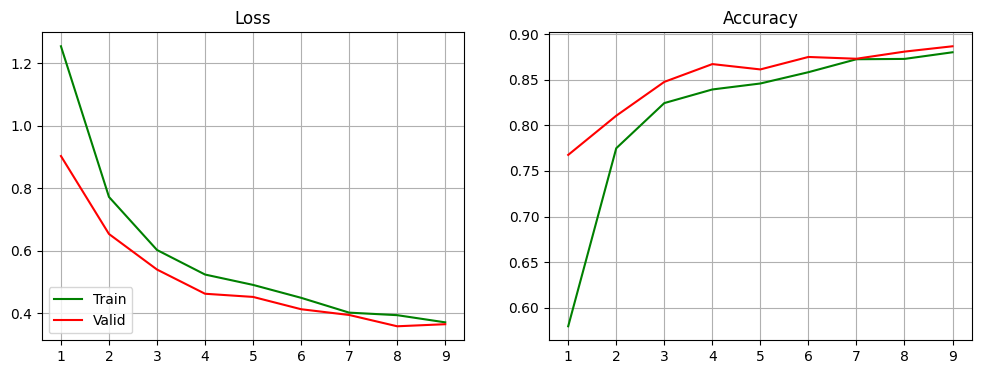

In [ ]:
ft126_history = process_and_display(history, tl_history)
model.save_weights('checkpoints/fine_tuning_125')

In [ ]:
setup_to_finetune(model, args, not_trainable=124) #odmrażamy kolejna warstwę

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/2
22/22 [==============================] - 91s 4s/step - loss: 0.3514 - accuracy: 0.8823 - val_loss: 0.3598 - val_accuracy: 0.8848
Epoch 2/2
22/22 [==============================] - 80s 4s/step - loss: 0.3336 - accuracy: 0.8951 - val_loss: 0.3154 - val_accuracy: 0.8965


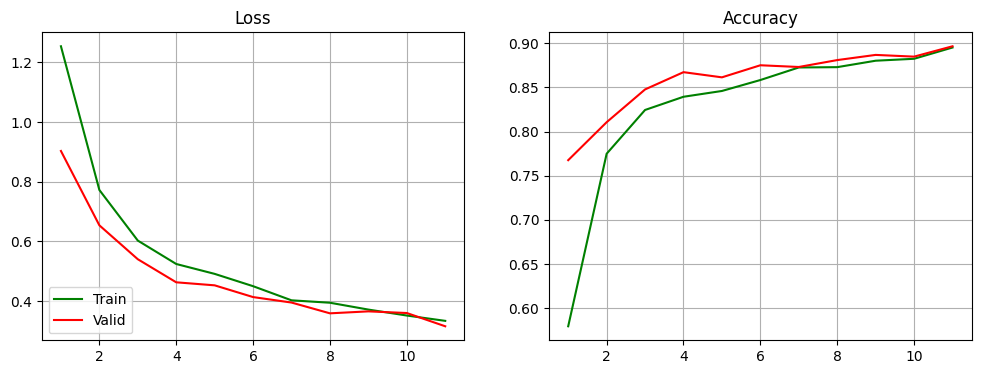

In [ ]:
ft126_history = process_and_display(history, tl_history)
model.save_weights('checkpoints/fine_tuning_124')

In [ ]:
setup_to_finetune(model, args, not_trainable=123) #odmrażamy kolejna warstwę

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/2
22/22 [==============================] - 88s 4s/step - loss: 0.3331 - accuracy: 0.8914 - val_loss: 0.3272 - val_accuracy: 0.8867
Epoch 2/2
22/22 [==============================] - 83s 4s/step - loss: 0.3184 - accuracy: 0.9049 - val_loss: 0.3370 - val_accuracy: 0.8887


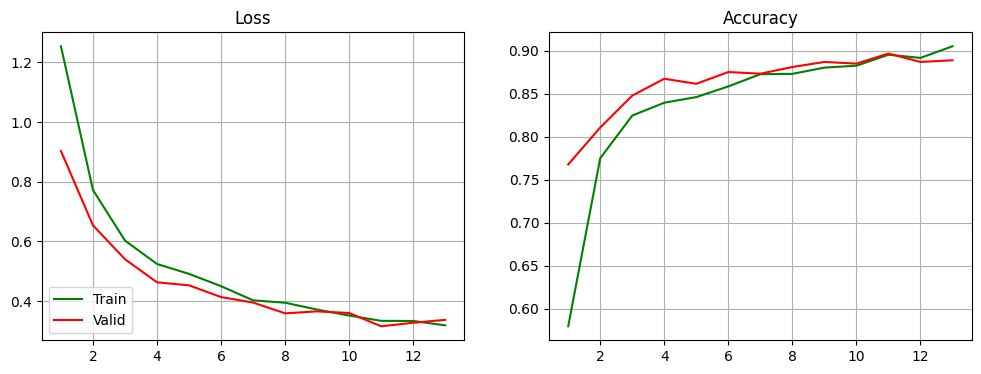

In [ ]:
ft126_history = process_and_display(history, tl_history)
model.save_weights('checkpoints/fine_tuning_123')

In [ ]:
setup_to_finetune(model, args, not_trainable=122) #odmrażamy kolejna warstwę

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/2
22/22 [==============================] - 84s 4s/step - loss: 0.3152 - accuracy: 0.8951 - val_loss: 0.3209 - val_accuracy: 0.8926
Epoch 2/2
22/22 [==============================] - 80s 4s/step - loss: 0.3033 - accuracy: 0.8998 - val_loss: 0.3231 - val_accuracy: 0.9004


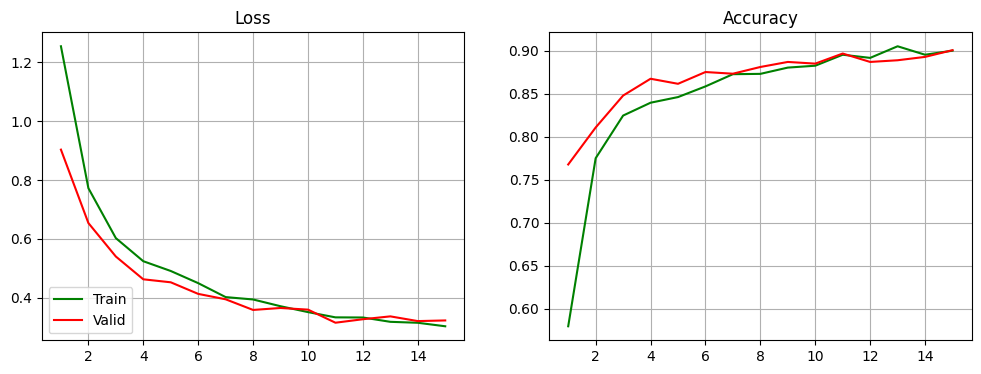

In [ ]:
ft126_history = process_and_display(history, tl_history)
model.save_weights('checkpoints/fine_tuning_122')

In [ ]:
setup_to_finetune(model, args, not_trainable=121) #odmrażamy kolejna warstwę

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/2
22/22 [==============================] - 82s 4s/step - loss: 0.3041 - accuracy: 0.8965 - val_loss: 0.2989 - val_accuracy: 0.9062
Epoch 2/2
22/22 [==============================] - 84s 4s/step - loss: 0.2952 - accuracy: 0.9060 - val_loss: 0.2989 - val_accuracy: 0.9023


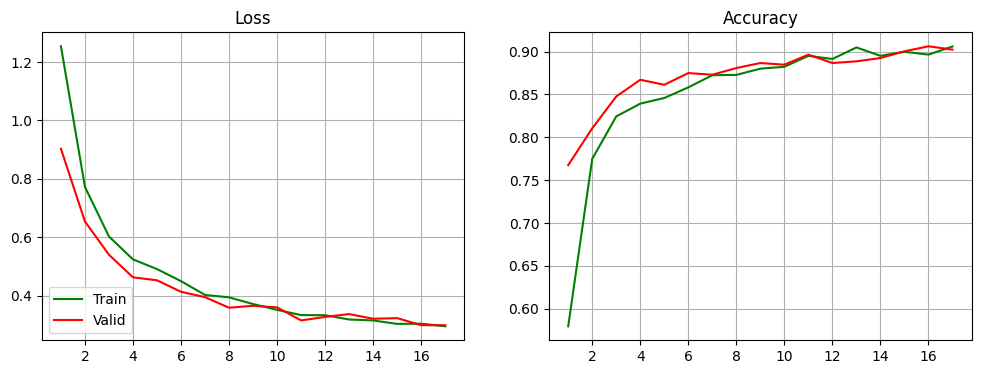

In [ ]:
ft126_history = process_and_display(history, tl_history)
model.save_weights('checkpoints/fine_tuning_121')

# Save the final model

In [ ]:
model.load_weights('checkpoints/fine_tuning_121')
model.save('checkpoints/final')

# TEST SCORES

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('checkpoints/final')

In [ ]:
nb_test_samples = get_nb_files(args.test_dir)
test_steps = int (nb_test_samples / args.batch_size)
model.evaluate(test_generator, steps=test_steps)

4/4 [==============================] - 82s 27s/step - loss: 0.2741 - accuracy: 0.9043


[0.2741430103778839, 0.904296875]

# TO DO
Show examples how your model works with real images.
Try to display:
- An image
- Real class of an image
- Estimated class of an image
- Probabilities

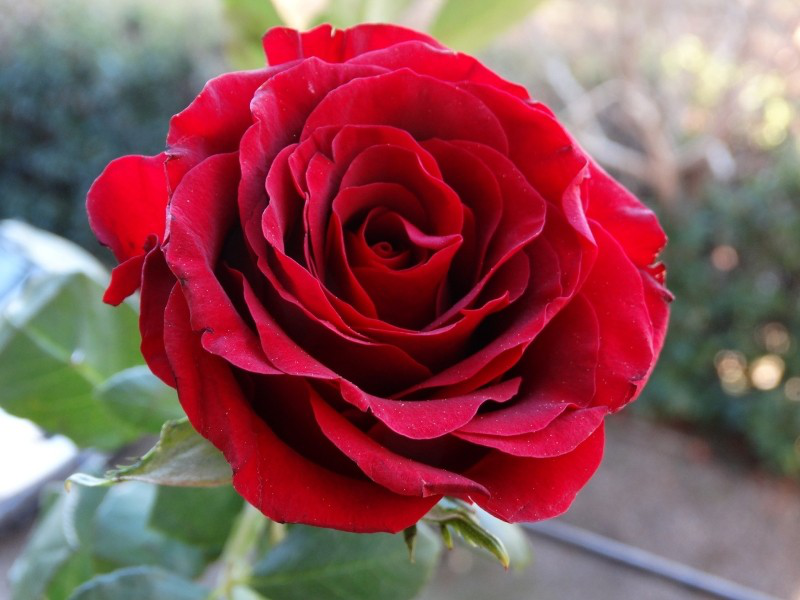

Real Class: rose
1/1 [==============================] - 2s 2s/step
Predicted Class: rose
Probabilities:
daisy: 0.02%
dandelion: 0.01%
rose: 99.33%
sunflower: 0.44%
tulip: 0.20%


In [ ]:
import os
from PIL import Image
import tensorflow as tf
import numpy as np

# Ścieżka do foldera z danymi
data_folder = '/content/drive/MyDrive/PROJEKTY/AI/splited dataset'  # Zmień na rzeczywistą ścieżkę do foldera z danymi
# Wczytuje wytrenowany model

model = tf.keras.models.load_model('checkpoints/final')  # Zmień na rzeczywistą ścieżkę do wcześniej wytrenowanego modelu
image  = Image.open('/content/drive/MyDrive/PROJEKTY/AI/splited dataset/rose.jpg')
image.show()
real_class = "rose"
print("Real Class:", real_class)
image = image.resize((299, 299))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0)
predictions = model.predict(image)
predictions = np.squeeze(predictions)
predicted_class_index = np.argmax(predictions)
predicted_class = "daisy" if predicted_class_index == 0 else "dandelion" if predicted_class_index == 1 else "rose" if predicted_class_index == 2 else "sunflower" if predicted_class_index == 3 else "tulip"
print("Predicted Class:", predicted_class)
print("Probabilities:")
print("daisy: {:.2f}%".format(100*predictions[0]))
print("dandelion: {:.2f}%".format(100*predictions[1]))
print("rose: {:.2f}%".format(100*predictions[2]))
print("sunflower: {:.2f}%".format(100*predictions[3]))
print("tulip: {:.2f}%".format(100*predictions[4]))


        # Wczytuje obrazek
#        image = Image.open(random_image_path)
#        image.show()

        # Przygotowuje obrazek do predykcji

 #       image = image.resize((299, 299))
 #       image = np.array(image) / 255.0
#        image = np.expand_dims(image, axis=0)

        # predykcja modelu

